# Zillow Clustering Project

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import zscore, iqr, percentileofscore, scoreatpercentile

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import wrangle_zillow as wr

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

# Acquire
The DataFrame below contains all fields from the `properties_2017` table as well as the descriptive fields from the appropriate tables in the `zillow` database. The data is filtered to only include properties that have a `latitude` and `longitude` value.

In [2]:
df = wr.get_zillow_data()
print(f"Our DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Our DataFrame has 77580 rows and 68 columns.


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01,NaN,NaN,NaN,Central,Single Family Residential,NaN,NaN
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,73681.0,119407.0,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,0.006940,2017-01-01,Central,NaN,NaN,Central,Condominium,NaN,NaN


> What kind of data types are we working with? How many null values are in each column?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77580 entries, 0 to 77579
Data columns (total 68 columns):
id                              77580 non-null int64
parcelid                        77580 non-null int64
airconditioningtypeid           25007 non-null float64
architecturalstyletypeid        207 non-null float64
basementsqft                    50 non-null float64
bathroomcnt                     77580 non-null float64
bedroomcnt                      77580 non-null float64
buildingclasstypeid             15 non-null float64
buildingqualitytypeid           49810 non-null float64
calculatedbathnbr               76964 non-null float64
decktypeid                      614 non-null float64
finishedfloor1squarefeet        6037 non-null float64
calculatedfinishedsquarefeet    77379 non-null float64
finishedsquarefeet12            73924 non-null float64
finishedsquarefeet13            42 non-null float64
finishedsquarefeet15            3027 non-null float64
finishedsquarefeet50          

> **We will need to address the abudance of null values and change some of the data types before we can begin our analysis.**

> Let's take a look at some of the summary statistics before we being preparing our data.

In [4]:
df.describe()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,7.758000e+04,7.758000e+04,25007.000000,207.000000,50.000000,77580.000000,77580.000000,15.000000,49810.000000,76964.000000,614.0,6037.000000,77379.000000,73924.000000,42.000000,3027.000000,6037.000000,386.000000,77580.000000,8289.000000,76964.000000,25520.000000,25520.000000,1539.0,49572.000000,7.758000e+04,7.758000e+04,6.932200e+04,16174.0,869.000000,465.0,1074.0,15079.0,77580.000000,7.758000e+04,76108.000000,77580.000000,30974.000000,77530.000000,77580.000000,50.0,10106.000000,223.000000,50704.000000,2393.000000,70.000000,77310.000000,17599.000000,172.0,7.746500e+04,7.757900e+04,77580.0,7.757800e+04,77575.000000,2900.000000,7.733300e+04,77580.000000
mean,1.495404e+06,1.300828e+07,1.812013,7.386473,679.720000,2.298492,3.053222,3.933333,6.533728,2.316388,66.0,1366.165314,1784.925923,1760.274945,1388.761905,2354.491245,1381.388935,2082.500000,6048.813998,1.191217,2.250104,1.815282,350.047061,1.0,3.921811,3.400837e+07,-1.182037e+08,2.997309e+04,1.0,517.930955,1.0,1.0,1.0,261.824465,6.049124e+07,33684.165817,2534.522235,187725.110544,96586.691539,1.476257,7.0,1.009598,6.040359,1.110307,305.460928,216.385714,1968.611396,1.434286,1.0,1.892796e+05,4.901476e+05,2016.0,3.011500e+05,5995.927626,14.088276,6.049667e+13,0.016800
std,8.609700e+05,3.519376e+06,2.965768,2.728030,689.703546,0.996726,1.140472,0.258199,1.722082,0.979684,0.0,670.701336,954.247864,934.349898,122.220874,1186.985442,725.792665,1240.382784,20.747162,0.490980,0.966486,0.588340,261.646070,0.0,3.594770,2.652856e+05,3.594078e+05,1.233042e+05,0.0,156.569664,0.0,0.0,0.0,5.141564,2.058953e+05,47212.464556,801.445328,165045.086058,3793.527616,2.823673,0.0,0.118572,0.556035,1.169955,238.735241,190.177514,23.793037,0.544515,0.0,2.304095e+05,6.537942e+05,0.0,4.927219e+05,7628.816490,2.181281,1.533329e+12,0.170739
min,3.490000e+02,1.071186e+07,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,66.0,44.000000,128.000000,128.000000,1056.000000,598.000000,44.000000,380.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.000000,3.333953e+07,-1.194754e+08,2.360000e+02,1.0,24.000000,1.0,1.0,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,4.000000,1.000000,11.000000,12.000000,1824.000000,1.000000,1.0,4.400000e+01,1.000000e+03,2016.0,1.610000e+02,19.920000,3.000000,6.037101e+13,-4.655420
25%,7.521430e+05,1.153820e+07,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,6.000000,2.000000,66.0,955.000000,1182.000000,1172.000000,1344.000000,1624.000000,956.000000,993.750000,6037.000000,1.000000,2.000000,2.000000,0.000000,1.0,2.000000,3.381463e+07,-1.184150e+08,5.700000e+03,1.0,424.000000,1.0,1.0,1.0,261.000000,6.037311e+07,12447.000000,1286.000000,46736.000000,96193.000000,0.000000,7.0,1.000000,6.000000,1.000000,170.000000,61.500000,1953.000000,1.000000,1.0,8.417100e+04,2.068990e+05,2016.0,8.529325e+04,2712.650000,14.000000,6.037311e+13,-0.024310
50%,1.498256e+06,1.253056e+07,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000,6.000000,2.000000,66.0,1257.000000,1542.000000,1523.000000,1440.000000,2088.000

> Finally, let's plot the distributions of the data to help us identify outliers that need to be addressed.

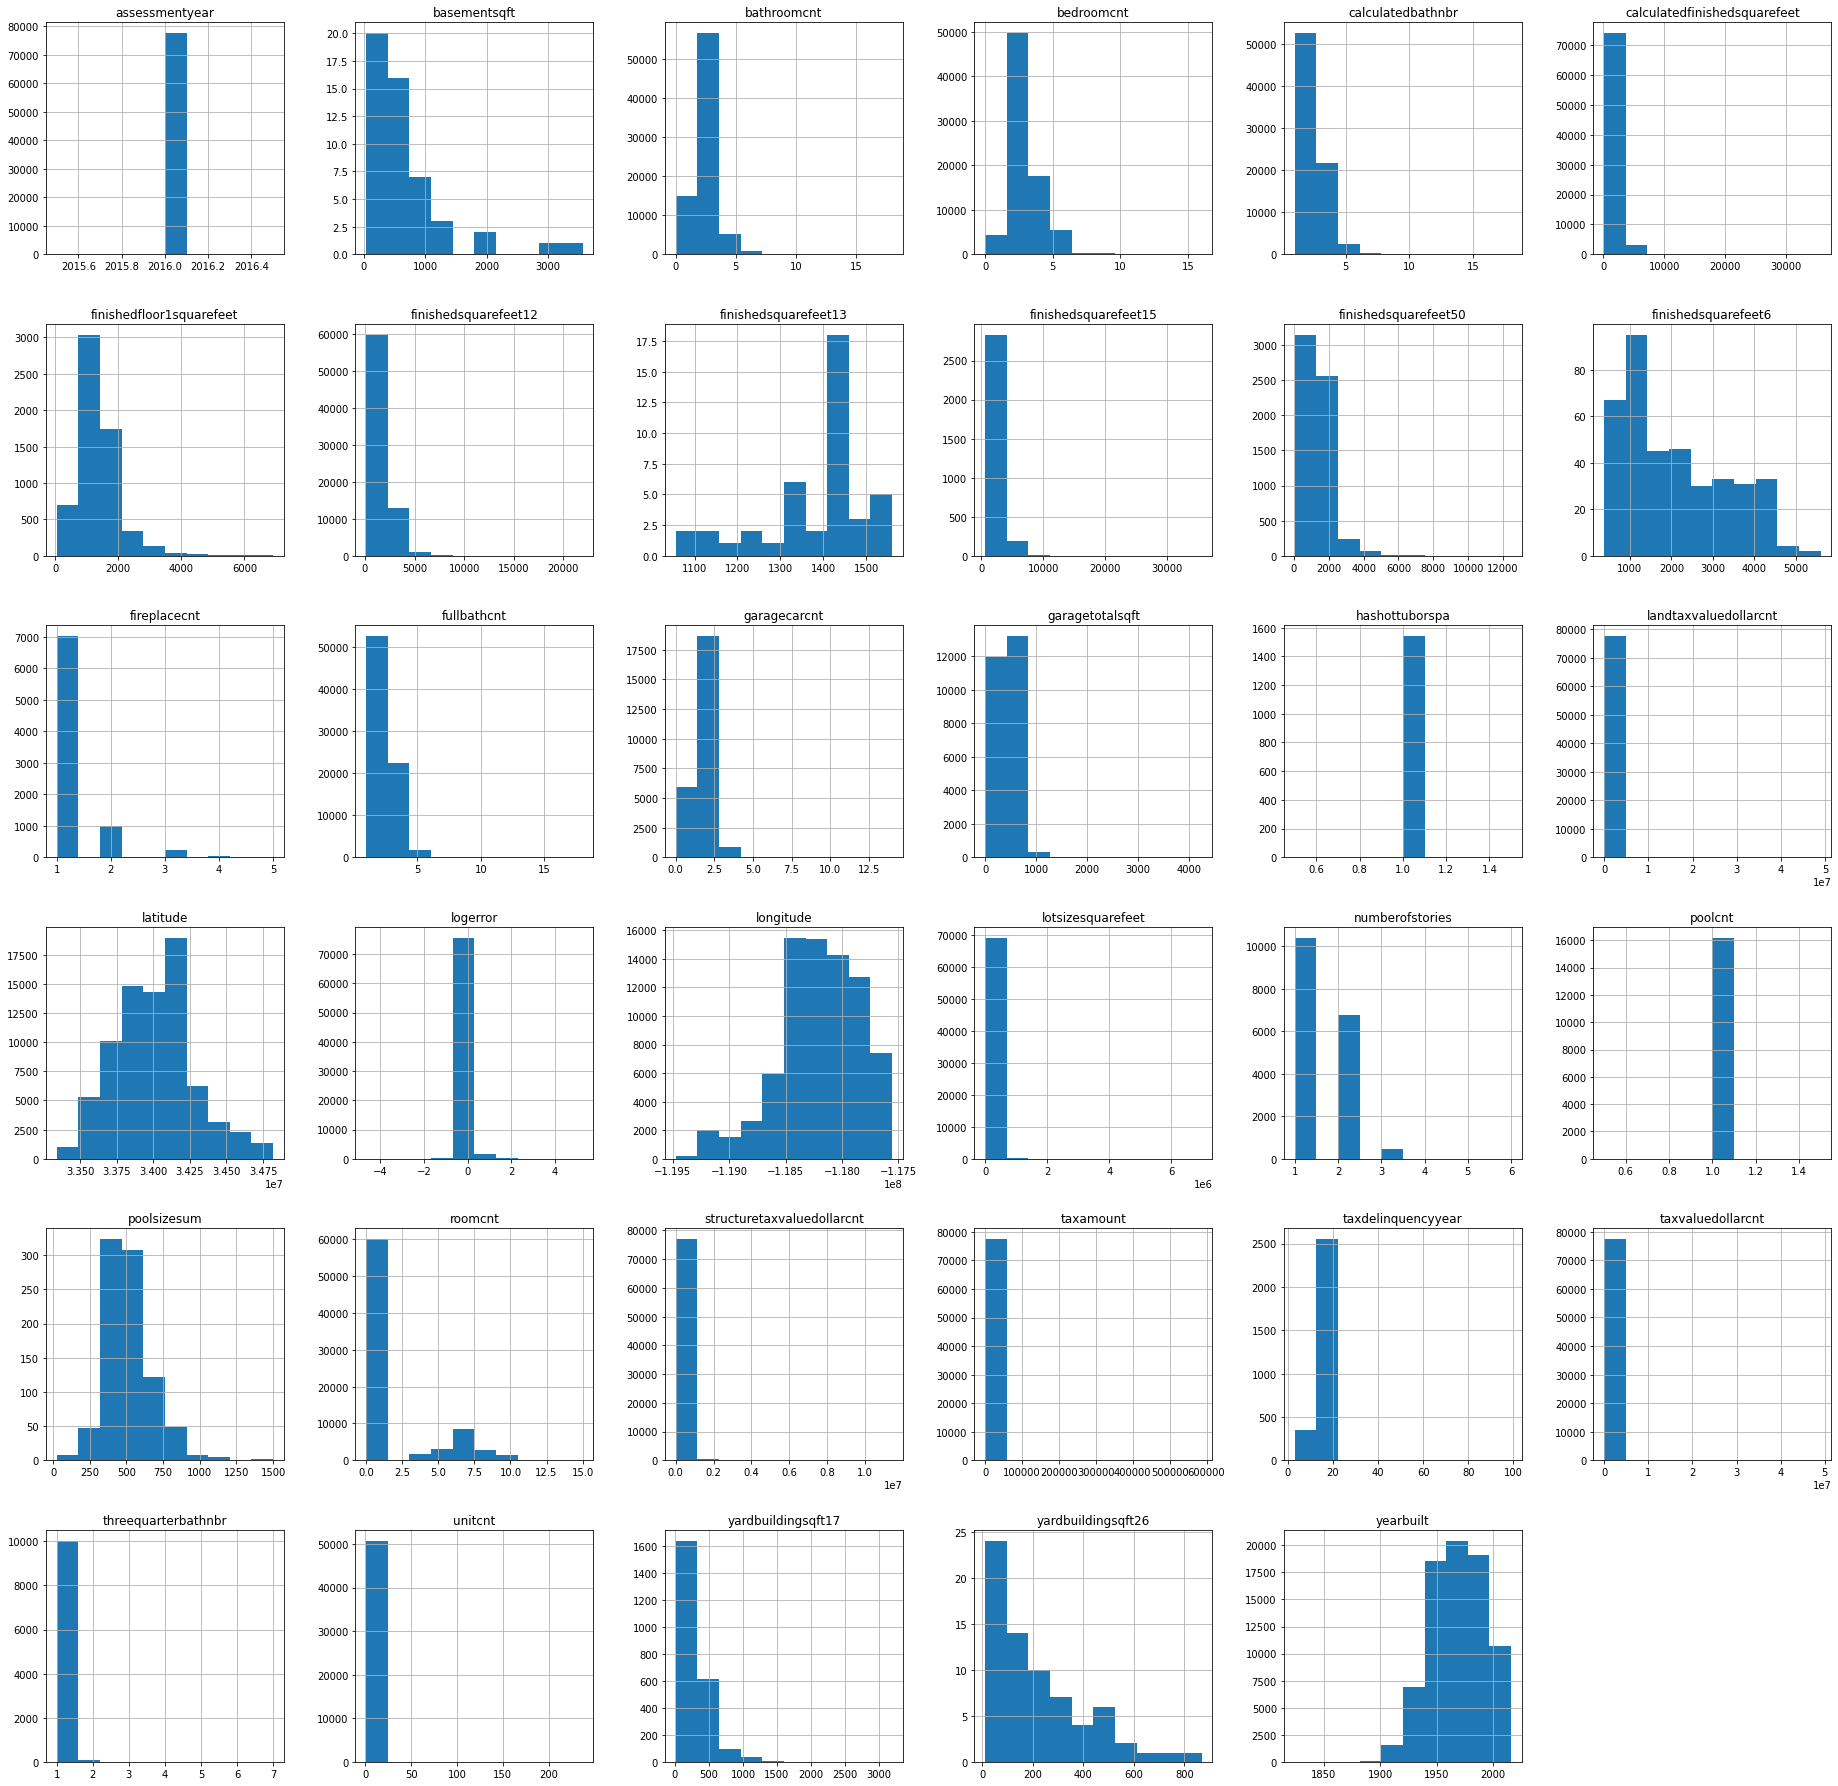

In [5]:
# let's drop the numeric id fields as they will not serve us in our hunt for outliers.
df.drop(columns=["id", "parcelid", "airconditioningtypeid", "architecturalstyletypeid", "buildingclasstypeid", "buildingqualitytypeid", "decktypeid", "fips", "heatingorsystemtypeid", "pooltypeid10", "pooltypeid2", "pooltypeid7", "propertylandusetypeid", "rawcensustractandblock", "regionidcity", "regionidcounty", "regionidneighborhood", "regionidzip", "storytypeid", "typeconstructiontypeid", "fireplaceflag", "censustractandblock"]).hist(figsize=(32, 32))
plt.show()

> **Now that we have a general idea of what our data looks like, let's move into preparation.**

---
# Prepare
## Explanation of `prep_zillow` function
The function does the following:
1. Removes any properties that cannot be interpreted as single unit/single family homes
2. Removes fields that will not add any value to our analysis (i.e., identifier fields and those with redundant information)
3. Drops columns and indices that are missing more than 60% of their respective data
4. Imputes missing values remaining after the function in number 3 has been called (excluding the `regionidcity` field)
5. Drops indices deemed unworthy of imputation either because there are too few values missing to put in the effort of imputing or imputation is not a practical means of handling the missing data (e.g., `censustractandblock`)
6. Creates new `county` and `tax_rate` variables
7. Handles outliers
8. Splits prepared DataFrame into `train`, `validate`, and `test`
9. KNN imputes the regionidcity for `train`, `validate`, and `test`
10. Scales all appropriate numeric fields for `train`, `validate`, and `test`
11. Returns the `imputer`, `scaler`, `train`, `validate`, and `test` variables

In [6]:
imputer, scaler, train, validate, test= wr.prep_zillow(df)
imputer

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=5, weights='uniform')

In [7]:
scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [8]:
print(f"   train shape = {train.shape}")
print(f"validate shape = {validate.shape}")
print(f"    test shape = {test.shape}")

   train shape = (31290, 31)
validate shape = (10431, 31)
    test shape = (10431, 31)


In [9]:
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate
30896,0.009697,0.000000,0.000000,0.272727,0.000000,0.039767,6037,0.000000,0.429497,0.640936,0.001013,0100,0.005844,396053,3101,95982,0.0,0.0,0.333333,0.001567,0.001077,0.0,0.000775,0.003098,0.000010,0.510391,2017-04-28,Floor/Wall,Single Family Residential,Los Angeles County,0.066047
19077,0.024845,0.291667,0.333333,0.454545,0.291667,0.239289,6059,0.250000,0.198432,0.956228,0.000999,122,0.296733,12773,1286,96996,0.0,0.0,0.797101,0.070274,0.067845,0.0,0.052443,0.056687,0.000519,0.543068,2017-03-22,None,Single Family Residential,Orange County,0.020079
49660,0.007067,0.000000,0.000000,0.454545,0.000000,0.026083,6037,0.000000,0.478220,0.638716,0.000827,010G,0.001437,12447,3101,95994,0.0,0.0,0.246377,0.007507,0.003399,0.0,0.000884,0.007662,0.000003,0.553112,2017-06-23,Central,Single Family Residential,Los Angeles County,0.053784
66688,0.004009,0.166667,0.333333,0.636364,0.166667,0.111035,6037,0.166667,0.889704,0.636147,0.001319,0100,0.010826,5534,3101,97319,0.0,0.0,0.956522,0.028482,0.013161,0.0,0.003240,0.027332,0.000019,0.569558,2017-08-15,Central,Single Family Residential,Los Angeles County,0.049981
36468,0.022685,0.208333,0.333333,0.454545,0.208333,0.164853,6059,0.166667,0.379497,0.868787,0.001489,1,0.296595,21412,1286,97078,0.0,0.0,0.920290,0.082015,0.055777,0.0,0.031614,0.052995,0.000519,0.565937,2017-05-16,None,Single Family Residential,Orange County,0.022855


In [10]:
train.isna().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
heatingorsystemdesc             0
propertylandusedesc             0
county        

In [11]:
validate.isna().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
heatingorsystemdesc             0
propertylandusedesc             0
county        

In [12]:
test.isna().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
logerror                        0
transactiondate                 0
heatingorsystemdesc             0
propertylandusedesc             0
county        

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31290 entries, 30896 to 49750
Data columns (total 31 columns):
parcelid                        31290 non-null float64
bathroomcnt                     31290 non-null float64
bedroomcnt                      31290 non-null float64
buildingqualitytypeid           31290 non-null float64
calculatedbathnbr               31290 non-null float64
calculatedfinishedsquarefeet    31290 non-null float64
fips                            31290 non-null object
fullbathcnt                     31290 non-null float64
latitude                        31290 non-null float64
longitude                       31290 non-null float64
lotsizesquarefeet               31290 non-null float64
propertycountylandusecode       31290 non-null object
rawcensustractandblock          31290 non-null float64
regionidcity                    31290 non-null object
regionidcounty                  31290 non-null object
regionidzip                     31290 non-null object
roomcnt     

In [14]:
train.describe()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,tax_rate
count,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000,31290.0,31290.000000,31290.000000,31290.000000,31290.0,31290.000000,31290.000000,31290.000000,31290.000000,31290.000000
mean,0.014721,0.108569,0.256468,0.470618,0.108558,0.081280,0.103212,0.461269,0.666993,0.001517,0.166482,0.127325,0.0,0.618606,0.021389,0.021631,0.0,0.017313,0.021954,0.000323,0.569802,0.026883
std,0.014930,0.084613,0.103100,0.125691,0.084597,0.046192,0.082676,0.185320,0.185535,0.010488,0.281780,0.210709,0.0,0.166672,0.028619,0.030653,0.0,0.028462,0.029746,0.005673,0.021990,0.012868
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.005255,0.083333,0.222222,0.454545,0.083333,0.051247,0.083333,0.329418,0.559605,0.000769,0.004062,0.000000,0.0,0.521739,0.008424,0.007807,0.0,0.003900,0.008882,0.000007,0.564370,0.023378
50%,0.012240,0.083333,0.222222,0.454545,0.083333,0.069339,0.083333,0.460621,0.688226,0.000942,0.007025,0.000000,0.0,0.594203,0.014362,0.015246,0.0,0.011328,0.015787,0.000012,0.568395,0.024776
75%,0.022394,0.166667,0.333333,0.545455,0.166667,0.098820,0.166667,0.572770,0.804376,0.001220,0.296872,0.333333,0.0,0.731884,0.024550,0.025124,0.0,0.021096,0.024963,0.000519,0.572687,0.027525
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


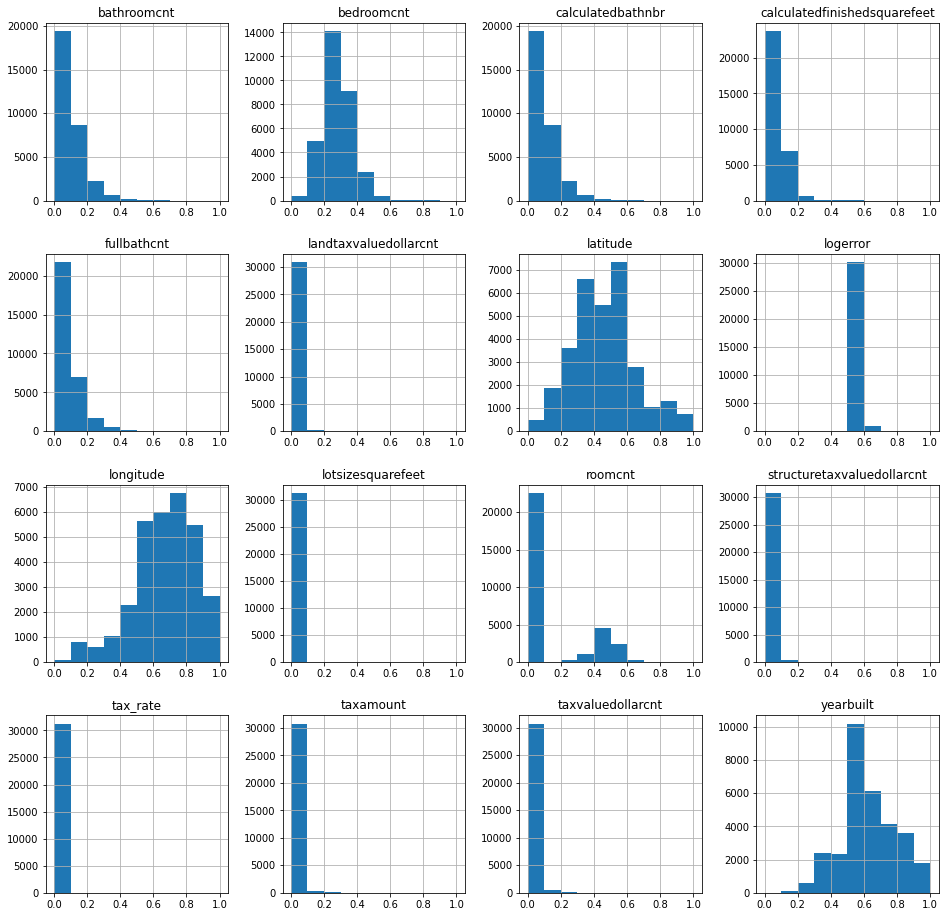

In [15]:
train = wr.convert_dtypes(train, columns=["parcelid", "buildingqualitytypeid", "unitcnt", "assessmentyear", "rawcensustractandblock", "censustractandblock"], dtype="object")
train.hist(figsize=(16, 16))
plt.show()

# Explore

In [16]:
# sns.pairplot(data=train)

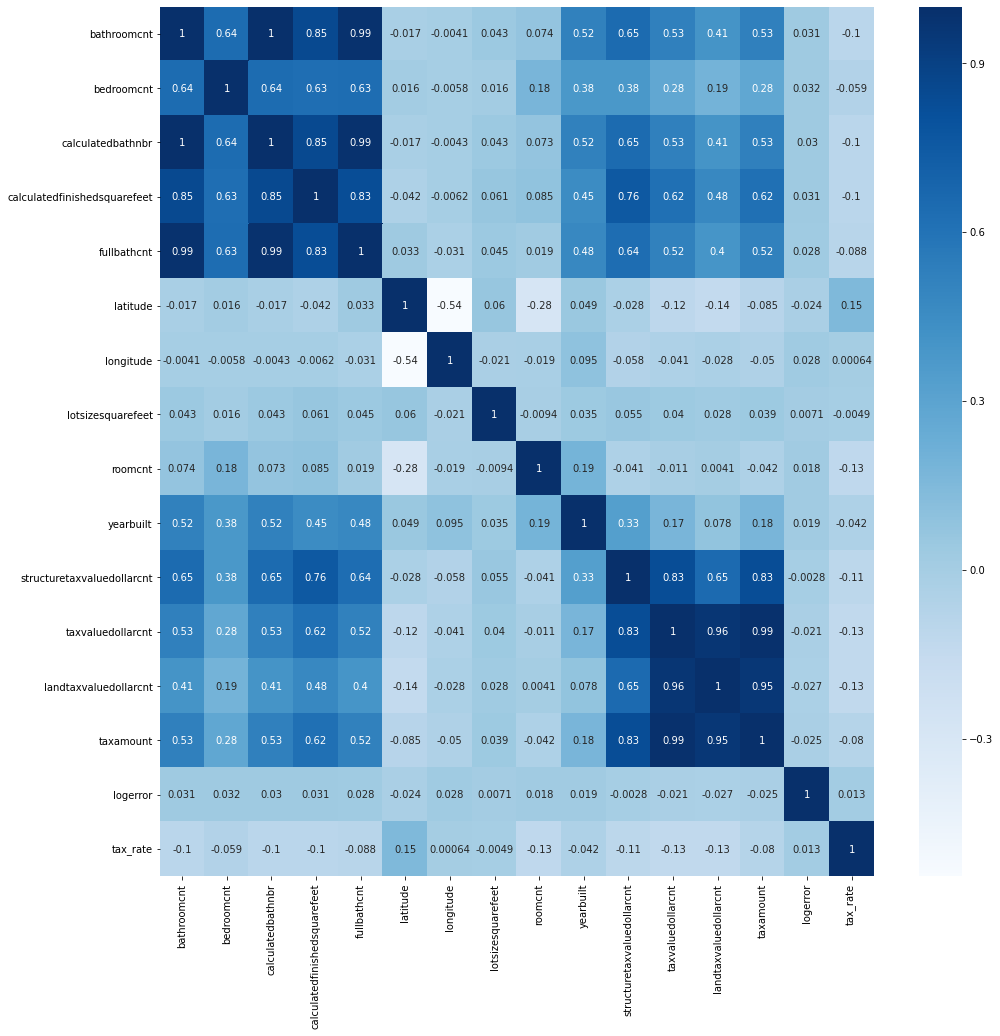

In [17]:
plt.figure(figsize=(16, 16))
sns.heatmap(train.corr(), annot=True, cmap="Blues")
plt.show()

## Cluster the Target Variable
Objectives:
1. Reduce the noise of the continuous variable so that trends in the data are more easily identifiable
2. Compare clusters with other variables through visualizations or hypothesis testing

In [18]:
X = train[["logerror"]]

In [19]:
# inital intuition of 6 clusters
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
kmeans.predict(X)

array([4, 4, 4, ..., 5, 0, 5], dtype=int32)

In [20]:
def get_inertia(k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    return kmeans.inertia_

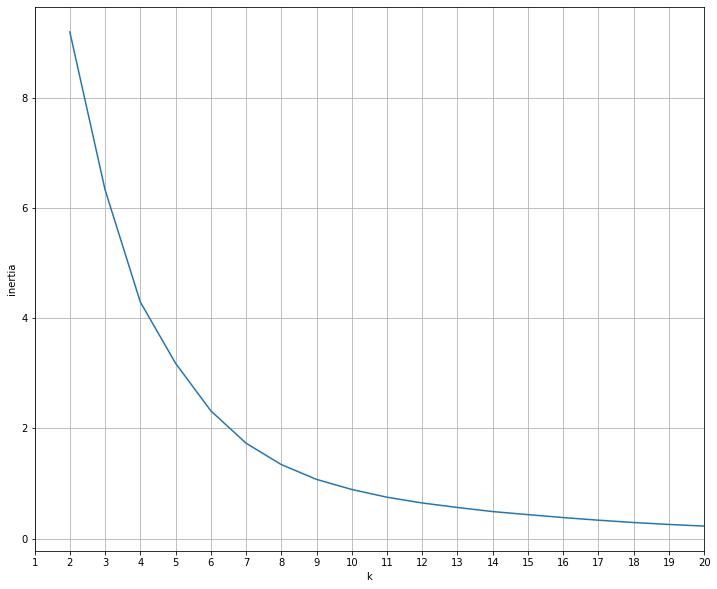

In [21]:
plt.figure(figsize=(12, 10))
pd.Series({k: get_inertia(k) for k in range(2, 21)}).plot()
plt.grid()
plt.xlabel("k")
plt.ylabel("inertia")
plt.xticks(range(1, 21))
plt.show()

In [22]:
# according to the elbow method above 7 clusters also seems reasonable
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
train["cluster_target"] = kmeans.predict(X)
train.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,heatingorsystemdesc,propertylandusedesc,county,tax_rate,cluster_target
30896,0.0096972,0.000000,0.000000,0.272727,0.000000,0.039767,6037,0.000000,0.429497,0.640936,0.001013,0100,0.00584363,396053,3101,95982,0.0,0,0.333333,0.001567,0.001077,0,0.000775,0.003098,1.02184e-05,0.510391,2017-04-28,Floor/Wall,Single Family Residential,Los Angeles County,0.066047,2
19077,0.0248451,0.291667,0.333333,0.454545,0.291667,0.239289,6059,0.250000,0.198432,0.956228,0.000999,122,0.296733,12773,1286,96996,0.0,0,0.797101,0.070274,0.067845,0,0.052443,0.056687,0.00051888,0.543068,2017-03-22,None,Single Family Residential,Orange County,0.020079,6
49660,0.00706735,0.000000,0.000000,0.454545,0.000000,0.026083,6037,0.000000,0.478220,0.638716,0.000827,010G,0.00143681,12447,3101,95994,0.0,0,0.246377,0.007507,0.003399,0,0.000884,0.007662,2.51248e-06,0.553112,2017-06-23,Central,Single Family Residential,Los Angeles County,0.053784,6
66688,0.00400907,0.166667,0.333333,0.636364,0.166667,0.111035,6037,0.166667,0.889704,0.636147,0.001319,0100,0.0108256,5534,3101,97319,0.0,0,0.956522,0.028482,0.013161,0,0.003240,0.027332,1.893e-05,0.569558,2017-08-15,Central,Single Family Residential,Los Angeles County,0.049981,0
36468,0.0226847,0.208333,0.333333,0.454545,0.208333,0.164853,6059,0.166667,0.379497,0.868787,0.001489,1,0.296595,21412,1286,97078,0.0,0,0.920290,0.082015,0.055777,0,0.031614,0.052995,0.000518638,0.565937,2017-05-16,None,Single Family Residential,Orange County,0.022855,0


In [23]:
kmeans.cluster_centers_

array([[0.57047136],
       [0.85016125],
       [0.51100609],
       [0.6544795 ],
       [0.29432741],
       [0.59468447],
       [0.55879606]])

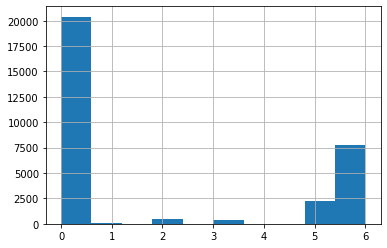

In [24]:
train.cluster_target.hist()

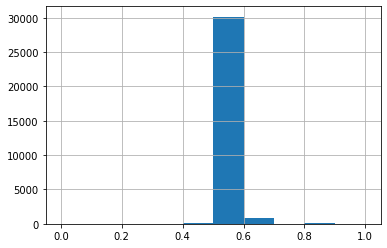

In [25]:
train.logerror.hist()